In [67]:
import pandas as pd
import numpy as np
import nltk
import re
import multiprocessing
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from gensim.models.word2vec import Word2Vec
from gensim.models.phrases import Phraser, Phrases
import seaborn as sns
import gensim
import logging
from nltk.corpus import stopwords
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
%matplotlib inline
plt.style.use('ggplot')

In [92]:
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return words
def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    vectors = [] # positions in vector space
    labels = [] # keep track of words to label our data again later
    for word in model.wv.vocab:
        vectors.append(model.wv[word])
        labels.append(word)

    # convert both lists into numpy vectors for reduction
    vectors = np.asarray(vectors)
    labels = np.asarray(labels)

    # reduce using t-SNE
    vectors = np.asarray(vectors)
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels

def plot_with_plotly(x_vals, y_vals, labels, cluster, plot_in_notebook=True):
    from plotly.offline import init_notebook_mode, iplot, plot
    import plotly.graph_objs as go


    trace = go.Scatter(x=x_vals, y=y_vals, mode='markers+text', text=labels,textposition='top center')
    data = [trace]

    if plot_in_notebook:
        init_notebook_mode(connected=True)
        iplot(data, filename='word-embedding-plot')
    else:
        plot(data, filename='word-embedding-plot.html')


def plot_with_matplotlib(x_vals, y_vals, labels):
    import matplotlib.pyplot as plt
    import random

    random.seed(0)
    
    plt.figure(figsize=(50, 50))
    plt.scatter(x_vals, y_vals)

    #
    # Label randomly subsampled 25 data points
    #
    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, 25)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))

try:
    get_ipython()
except Exception:
    plot_function = plot_with_matplotlib
else:
    plot_function = plot_with_plotly

In [53]:
breitbart_csv = 'breitbart_articles_titles.csv'
cnn_csv = 'cnn_articles.csv'
dailywire_csv = 'daily_wire.csv'
reuters_csv = 'reuters_articles.csv'
csv_files = [breitbart_csv, cnn_csv, dailywire_csv, reuters_csv]

dataframes = [None] * len(csv_files)

for i in range(len(dataframes)):
    dataframe = pd.read_csv(csv_files[i])
    dataframes[i] = dataframe.iloc[:100]
dataframes

[    Unnamed: 0                                            product  \
 0            0  GOP Lawmakers: Joe Biden’s Border Policies a ‘...   
 1            1  Disney World Tickets Sold Out for Spring Break...   
 2            2  Democrat Abigail Spanberger Flip-Flops in Favo...   
 3            3  Joe Biden Prioritizes Migrant Youth ‘Education...   
 4            4  White House Returns Portraits of Clinton, Bush...   
 ..         ...                                                ...   
 95          95  House VA Panel Announces Probe into ‘Extremist...   
 96          96  Report: Lincoln Project Cofounders Knew of Joh...   
 97          97  White House: Joe Biden Opposes Bipartisan Effo...   
 98          98  Exclusive – Rep. Darrell Issa ‘Absolutely’ Sup...   
 99          99  Capitol Security Report Suggests Creation of P...   
 
                                                  link  \
 0   /politics/2021/03/08/gop-lawmakers-joe-bidens-...   
 1   /politics/2021/03/09/disney-world-tic

In [54]:
df = pd.concat(dataframes)
df = df.drop('Unnamed: 0',axis=1)
df

,product,link,article_content,source
0,GOP Lawmakers: Joe Biden’s Border Policies a ‘...,/politics/2021/03/08/gop-lawmakers-joe-bidens-...,A group of 23 House Republicans has sent a let...,breitbart
1,Disney World Tickets Sold Out for Spring Break...,/politics/2021/03/09/disney-world-tickets-sold...,The “happiest place on Earth” will be bursting...,breitbart
2,Democrat Abigail Spanberger Flip-Flops in Favo...,/politics/2021/03/09/democrat-abigail-spanberg...,Rep. Abigail Spanberger (D-VA) voted Tuesday a...,breitbart
3,Joe Biden Prioritizes Migrant Youth ‘Education...,/politics/2021/03/09/joe-biden-migrant-youth-e...,President Joe Biden’s administration is focuse...,breitbart
4,"White House Returns Portraits of Clinton, Bush...",/politics/2021/03/09/white-house-returns-portr...,The White House announced the return of portra...,breitbart
...,...,...,...,...
95,Kremlin rejects U.S. allegation Russia is tryi...,https://www.reuters.com/article/us-usa-russia-...,MOSCOW (Reuters) - The Kremlin on Tuesday rebu...,Reuters
96,Poland to resume some logging in ancient Bialo...,https://www.reuters.com/article/us-poland-eu-b...,WARSAW (Reuters) - Poland will resume some log...,Reuters
97,China launches COVID-19 vaccination certificat...,https://www.reuters.com/article/us-health-coro...,BEIJING (Reuters) - China has launched a digit...,Reuters
98,Irked Thai PM sprays reporters with hand sanit...,https://www.reuters.com/article/us-thailand-po...,BANGKOK (Reuters) - Thai Prime Minister Prayut...,Reuters


In [55]:
df = df.drop_duplicates()
df = df.dropna()

In [56]:
raw_corpus = ''
row_count = 0
for row in df.article_content:    
    print('Adding to raw_corpus... \n row_num is {row_count}'.format(row_count=row_count))
    row_count += 1
    raw_corpus += row

Adding to raw_corpus... 
 row_num is 0
Adding to raw_corpus... 
 row_num is 1
Adding to raw_corpus... 
 row_num is 2
Adding to raw_corpus... 
 row_num is 3
Adding to raw_corpus... 
 row_num is 4
Adding to raw_corpus... 
 row_num is 5
Adding to raw_corpus... 
 row_num is 6
Adding to raw_corpus... 
 row_num is 7
Adding to raw_corpus... 
 row_num is 8
Adding to raw_corpus... 
 row_num is 9
Adding to raw_corpus... 
 row_num is 10
Adding to raw_corpus... 
 row_num is 11
Adding to raw_corpus... 
 row_num is 12
Adding to raw_corpus... 
 row_num is 13
Adding to raw_corpus... 
 row_num is 14
Adding to raw_corpus... 
 row_num is 15
Adding to raw_corpus... 
 row_num is 16
Adding to raw_corpus... 
 row_num is 17
Adding to raw_corpus... 
 row_num is 18
Adding to raw_corpus... 
 row_num is 19
Adding to raw_corpus... 
 row_num is 20
Adding to raw_corpus... 
 row_num is 21
Adding to raw_corpus... 
 row_num is 22
Adding to raw_corpus... 
 row_num is 23
Adding to raw_corpus... 
 row_num is 24
Adding to 

In [57]:
raw_corpus = raw_corpus.replace(u'\xa0', u' ')

In [58]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
raw_sentences = tokenizer.tokenize(raw_corpus)
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence.lower()))

In [59]:
stopWords = list(stopwords.words('english'))
sent_remove_stopwords = []
for sent in sentences:
    append_sent = []
    for word in sent:
        if word not in stopWords:
            append_sent.append(word)
    sent_remove_stopwords.append(append_sent)

In [60]:
phrases = Phrases(sent_remove_stopwords, common_terms=stopWords)
bigram = Phraser(phrases)

2021-03-13 22:02:16,691 : INFO : collecting all words and their counts
2021-03-13 22:02:16,692 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2021-03-13 22:02:16,874 : INFO : collected 116609 word types from a corpus of 133632 words (unigram + bigrams) and 6018 sentences
2021-03-13 22:02:16,874 : INFO : using 116609 counts as vocab in Phrases<0 vocab, min_count=5, threshold=10.0, max_vocab_size=40000000>
2021-03-13 22:02:16,875 : INFO : source_vocab length 116609
2021-03-13 22:02:17,775 : INFO : Phraser built with 757 phrasegrams


In [61]:
all_sentences = list(bigram[sent_remove_stopwords])

In [50]:
all_sentences[:1000]

[['group',
  'house',
  'republicans',
  'sent',
  'letter',
  'department',
  'homeland',
  'security',
  'dhs',
  'secretary',
  'alejandro',
  'mayorkas',
  'demanding',
  'answers',
  'many',
  'border_crossers',
  'testing',
  'positive',
  'chinese',
  'coronavirus',
  'subsequently',
  'released',
  'united_states',
  'interior',
  'letter',
  'led',
  'rep',
  'michael',
  'burgess',
  'r',
  'tx',
  'calls',
  'president',
  'joe_biden',
  'policies',
  'u',
  'mexico',
  'border',
  'thousands',
  'border_crossers',
  'migrants',
  'released',
  'nation',
  'interior',
  'enrolled',
  'remain',
  'mexico',
  'program',
  'tested',
  'coronavirus',
  'others',
  'released',
  'sometimes',
  'tested',
  'local',
  'communities',
  'sent',
  'way',
  'regardless',
  'test',
  'results',
  'reports',
  'least',
  'migrants',
  'tested',
  'positive',
  'coronavirus',
  'released',
  'united_states',
  'letter',
  'states',
  'reports',
  'last_week',
  'confirmed',
  'border_cros

In [62]:
model = Word2Vec(sentences=all_sentences, min_count=3, size=1000, workers=10)

2021-03-13 22:02:20,341 : INFO : collecting all words and their counts
2021-03-13 22:02:20,341 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-03-13 22:02:20,365 : INFO : collected 16524 word types from a corpus of 125043 raw words and 6018 sentences
2021-03-13 22:02:20,365 : INFO : Loading a fresh vocabulary
2021-03-13 22:02:20,384 : INFO : effective_min_count=3 retains 7461 unique words (45% of original 16524, drops 9063)
2021-03-13 22:02:20,386 : INFO : effective_min_count=3 leaves 113517 word corpus (90% of original 125043, drops 11526)
2021-03-13 22:02:20,401 : INFO : deleting the raw counts dictionary of 16524 items
2021-03-13 22:02:20,403 : INFO : sample=0.001 downsamples 7 most-common words
2021-03-13 22:02:20,403 : INFO : downsampling leaves estimated 111947 word corpus (98.6% of prior 113517)
2021-03-13 22:02:20,418 : INFO : estimated required memory for 7461 words and 1000 dimensions: 63418500 bytes
2021-03-13 22:02:20,419 : INFO : resetting l

In [80]:
x_vals, y_vals, labels = reduce_dimensions(model)

try:
    get_ipython()
except Exception:
    plot_function = plot_with_matplotlib
else:
    plot_function = plot_with_plotly
plot_function(x_vals, y_vals, labels, groups)

C:\Users\ryan\anaconda3\envs\word2vec\lib\site-packages\_plotly_utils\basevalidators.py:575: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



ValueError: 
    Invalid value of type 'numpy.ndarray' received for the 'fill' property of scatter
        Received value: array([7, 3, 5, ..., 6, 6, 1])

    The 'fill' property is an enumeration that may be specified as:
      - One of the following enumeration values:
            ['none', 'tozeroy', 'tozerox', 'tonexty', 'tonextx',
            'toself', 'tonext']

In [91]:
plot_function(x_vals, y_vals, labels, groups)

AttributeError: 'Scatter' object has no attribute 'update_traces'

In [64]:
X = []
zip_obj = zip(x_vals,y_vals)
for x,y in zip_obj:
    X.append([x,y])
X

[[-35.534153, -58.033134],
 [-0.6795189, 1.1122189],
 [-86.66726, 6.112153],
 [-84.108986, 11.584095],
 [17.918665, 70.84267],
 [-46.13521, -48.114113],
 [71.22282, -32.086407],
 [-88.11314, -12.248837],
 [-14.720884, 47.979362],
 [4.4460893, 25.28452],
 [88.04137, -9.998778],
 [2.8408856, 48.035053],
 [-31.640581, -61.704777],
 [-47.609562, -9.321021],
 [-51.95185, 39.196312],
 [41.23847, -57.211502],
 [-62.057312, -29.054274],
 [-45.900204, -48.365646],
 [-13.5169115, -47.4234],
 [-48.634277, -45.231876],
 [-35.791767, -57.778122],
 [-41.371998, 7.475142],
 [-66.76781, -25.369268],
 [-59.10072, -31.934818],
 [-46.880447, 0.62855715],
 [-86.89416, 5.522057],
 [-48.390575, -6.0174794],
 [-87.73498, 2.998351],
 [-65.350006, -26.408249],
 [-30.58654, -62.678715],
 [-61.35419, -29.69918],
 [-4.5231586, 74.62926],
 [-38.98038, -54.837597],
 [-51.60552, 38.968754],
 [-54.21578, -37.88984],
 [-85.51165, 8.769006],
 [-17.11207, 9.250542],
 [-18.121017, 1.789808],
 [-52.673485, -39.943813],
 [

In [79]:
from sklearn.cluster import SpectralClustering
clustering = SpectralClustering().fit(X)
groups = clustering.labels_
plt.figure(figsize=(8,8))
sns.scatterplot(x=x_vals,y=y_vals,hue=groups,palette='deep',legend='full')
plt.legend()

KeyboardInterrupt: 

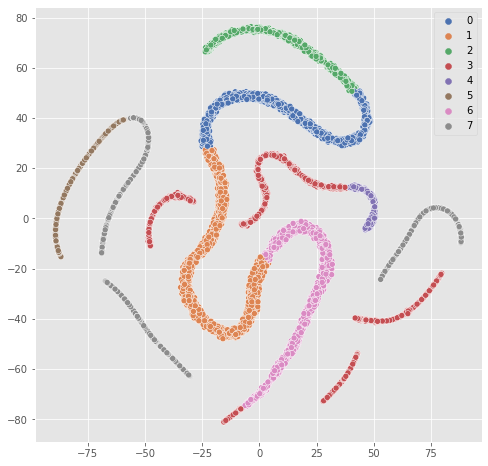

In [69]:
plt.figure(figsize=(8,8))
sns.scatterplot(x=x_vals,y=y_vals,hue=groups,palette='deep',legend='full')
plt.legend()

In [71]:
words = ['house_republicans','democrat','biden']
for word in words:
    result = model.wv.most_similar(word)
    print(result)

[('u', 0.9998445510864258), ('women', 0.999843955039978), ('children', 0.999843955039978), ('public', 0.9998438954353333), ('could', 0.9998437762260437), ('group', 0.9998437166213989), ('school', 0.9998435974121094), ('without', 0.9998434782028198), ('schools', 0.9998434782028198), ('trump', 0.9998432397842407)]
[('said', 0.9999943971633911), ('also', 0.9999940395355225), ('two', 0.9999938607215881), ('state', 0.9999938011169434), ('would', 0.9999938011169434), ('could', 0.9999938011169434), ('one', 0.9999936819076538), ('including', 0.9999936819076538), ('u', 0.9999935030937195), ('made', 0.9999935030937195)]
[('said', 0.9999958872795105), ('would', 0.9999956488609314), ('also', 0.9999954104423523), ('one', 0.9999953508377075), ('two', 0.9999953508377075), ('u', 0.9999952912330627), ('first', 0.9999951124191284), ('made', 0.9999951124191284), ('could', 0.9999950528144836), ('china', 0.9999950528144836)]
